In [50]:
# Install necessary libraries
!pip install pandas-datareader
!pip install --upgrade cvxpy

In [51]:
# Import required libraries
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pandas as pd
import scipy.cluster.hierarchy as sch
import seaborn as sns
from pandas_datareader import DataReader
from scipy.stats import mode
from cvxpy import Variable, Minimize, Problem, norm
import cvxpy as cp

In [52]:
# Function to find the nearest correlation matrix
def nearest_correlation(matrix):
    n = matrix.shape[0]
    X = cp.Variable((n, n), symmetric=True)
    constraints = [
        X >> 0,  # Positive semi-definite
        cp.diag(X) == 1  # Diagonal elements are 1
    ]
    objective = cp.Minimize(cp.norm(matrix - X, 'fro'))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return X.value


Motivation:

-- Correlation and covariance matrices are input parameters for a wide variety of financial models  

-- However, they are prone to estimation error due to outliers, noise, etc.

-- Poor estimates may have a significant negative impact on subsequent model results

-- We examine one technique for reducing this error, and consider how the raw and filtered S&P 500 covariance matrices that we construct minimally alter a Markowitz-type optimal portfolio using CVXPY

Outline of Talk:

1) Download and wrangle S&P 500 daily price data from Google Finance.

2) Simulate time series with heavy-tailed daily returns.  Estimate their correlation matrix and examine the distribution of its eigenvalues.

3) Review a theorem of Marchenko and Pastur related to the functional form of this eigenvalue distribution.

4) Apply these results to the S&P 500 return data and use them to develop an eigenvalue based noise filter.

5) Apply the noise filter, reconstruct the correlation matrix, and find the "nearest" correlation matrix to the filtered matrix.

6) Examine how the filtered correlation matrix has a minimal affect on the results of a Markowitz type asset allocation optimization problem.

In [53]:
import pandas as pd
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf



# Download S&P 500 ticker symbols
url = 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/refs/heads/main/data/constituents.csv'
tickerdf = pd.read_csv(url)

# Print the first few tickers to verify
print("Loaded tickers:")
print(tickerdf['Symbol'].head())  # Inspect the first few tickers

# Choose every 10th ticker from the list
tickers = tickerdf['Symbol'][::10]

# Format tickers (replace periods with hyphens)
tickers = tickers.str.replace('.', '-', regex=False)

# Print the first few formatted tickers to verify
print("Formatted tickers:")
print(tickers[:10])  # Print first 10 formatted tickers

verbose_flag = True  # Set to True for more verbose output

# Download stock data
start_date = dt.datetime(2020, 1, 1)
ticker_df_list = []

for ticker in tickers:
    try:
        r = yf.Ticker(ticker).history(start=start_date)
        r['Ticker'] = ticker
        ticker_df_list.append(r)
        if verbose_flag:
            print(f"Obtained data for ticker {ticker}")
    except Exception as e:
        if verbose_flag:
            print(f"No data for ticker {ticker}: {e}")



# Combine stock data if any was downloaded
if ticker_df_list:
    df = pd.concat(ticker_df_list)
    cell = df[['Ticker', 'Close']]
    cell = cell.reset_index().sort_values(['Ticker', 'Date'], ascending=[True, False]).set_index('Ticker')
    cell.to_pickle('google_close_price.pkl')
    print("Data successfully downloaded and saved.")
else:
    print("No data was downloaded.")


Loaded tickers:
0     MMM
1     AOS
2     ABT
3    ABBV
4     ACN
Name: Symbol, dtype: object
Formatted tickers:
0       MMM
10      APD
20     GOOG
30      AWK
40     AMAT
50      ADP
60    BRK-B
70      BSX
80     CDNS
90      CAT
Name: Symbol, dtype: object
Obtained data for ticker MMM
Obtained data for ticker APD
Obtained data for ticker GOOG
Obtained data for ticker AWK
Obtained data for ticker AMAT
Obtained data for ticker ADP
Obtained data for ticker BRK-B
Obtained data for ticker BSX
Obtained data for ticker CDNS
Obtained data for ticker CAT
Obtained data for ticker SCHW
Obtained data for ticker C
Obtained data for ticker COP
Obtained data for ticker COST
Obtained data for ticker DAY
Obtained data for ticker DG
Obtained data for ticker EMN
Obtained data for ticker ETR
Obtained data for ticker EG
Obtained data for ticker FICO
Obtained data for ticker F
Obtained data for ticker GEHC
Obtained data for ticker GL
Obtained data for ticker HES
Obtained data for ticker HUBB
Obtained da

In [54]:
# Combine stock data
if ticker_df_list:
    df = pd.concat(ticker_df_list)
    cell = df[['Ticker', 'Close']]
    cell = cell.reset_index().sort_values(['Ticker', 'Date'], ascending=[True, False]).set_index('Ticker')
    cell.to_pickle('google_close_price.pkl')
else:
    print("No data was downloaded.")

In [55]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2020-01-02 00:00:00-05:00,135.411605,137.187324,135.000063,137.179703,4307633,0.0,0.0,MMM
2020-01-03 00:00:00-05:00,134.908631,136.158484,133.849290,135.998444,2950412,0.0,0.0,MMM
2020-01-06 00:00:00-05:00,135.007721,136.196616,134.398031,136.128021,2389608,0.0,0.0,MMM
2020-01-07 00:00:00-05:00,135.868895,136.044193,134.756217,135.579300,2598908,0.0,0.0,MMM
2020-01-08 00:00:00-05:00,135.655524,138.322909,135.388780,137.659866,3298927,0.0,0.0,MMM


In [56]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2024-12-02 00:00:00-05:00,409.290009,412.459991,406.600006,410.040009,294200,0.0,0.0,ZBRA
2024-12-03 00:00:00-05:00,408.609985,409.730011,404.679993,406.399994,304700,0.0,0.0,ZBRA
2024-12-04 00:00:00-05:00,408.709991,412.940002,407.769989,411.940002,230100,0.0,0.0,ZBRA
2024-12-05 00:00:00-05:00,412.989990,413.269989,404.320007,404.980011,299600,0.0,0.0,ZBRA
2024-12-06 00:00:00-05:00,406.600006,413.059998,405.200012,409.320007,222800,0.0,0.0,ZBRA


We first simulate time series whose differences are drawn from a heavy tailed distribution. Specifically, we:

1) Take 2000 draws from a Student's t distribution with degree of freedom parameter 5 for 500 paths

2) Compute the cumulative sum of each time series and plot the results in the first figure below

3) Plot the distribution of differences of one of the time series in the second plot below

4) Estimate the correlation matrix between the different series, compute its eigenvalues, and plot their histogram in the third plot

In [57]:
# Simulate heavy-tailed time series
deg_freedom = 5
num_srs = 500
num_pts = 2000
rpaths = np.random.standard_t(deg_freedom, size=(num_pts, num_srs))


In [58]:
# Correlation matrix and eigenvalues
corr_matrix = pd.DataFrame(rpaths).corr()
cov_matrix = pd.DataFrame(rpaths).cov()
eigenvalues, eigenvectors = la.eig(corr_matrix)

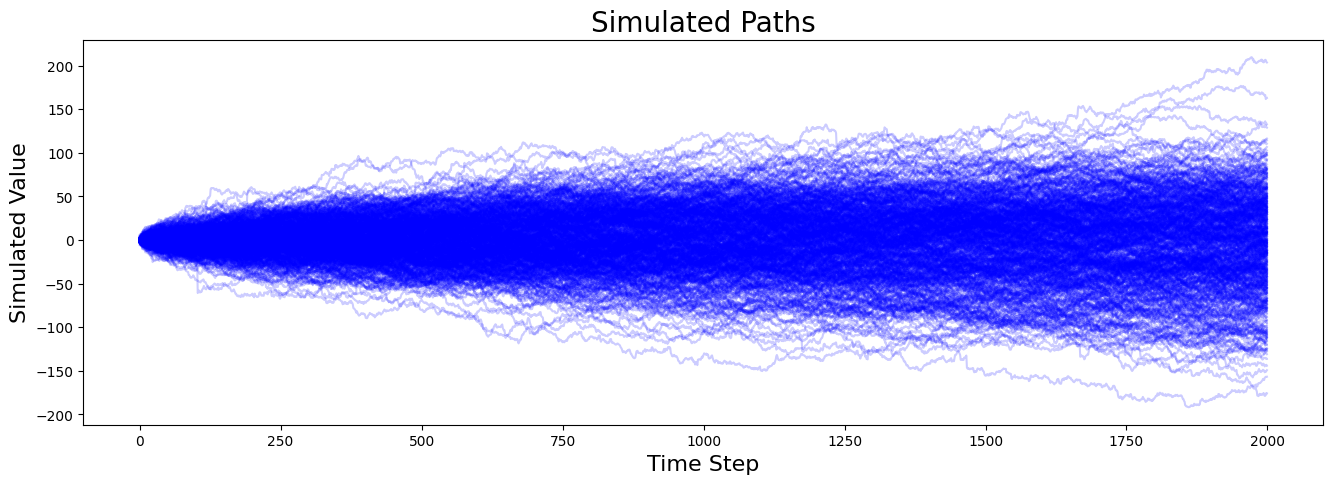

In [59]:
# Plot results
plt.figure(figsize=(16, 5))
plt.plot(rpaths.cumsum(axis=0), alpha=0.2, color='blue')
plt.xlabel("Time Step", fontsize=16)
plt.ylabel("Simulated Value", fontsize=16)
plt.title("Simulated Paths", fontsize=20)
plt.show()

Note that the eigenvalue distribution has an interesting shape.  We paraphrase a theorem of Marchenko and Pastur that describes the functional form of this shape:


Let $X$ be a random $n\times r$ matrix whose entries are i.i.d. and have finite constant variance $\sigma^2$.  Then the eigenvalues of the correlation matrix corresponding to $X$ are distributed according to
$$
f(\lambda)=\frac{q}{2\pi\lambda}\sqrt{(\lambda_+ - \lambda)(\lambda-\lambda_-)}
\:\:\mathrm{for} \:\: \lambda\in[\lambda_-,\lambda_+] \:\:
\mathrm{where\:\:} \lambda_{\pm} = 1+\frac{1}{q}\pm 2\sqrt{\frac{1}{q}} \:\: \mathrm{and} \:\: q = \frac{n}{r}
$$

We plot this function overlaid on the eigenvalue histogram below.

In our application, the columns of $X$ will correspond to normalized stock daily return time series.  

In [60]:
# Marchenko-Pastur distribution
def eigden(lam, n, r):
    q = float(n) / r
    lplus = 1 + 1/q + 2*np.sqrt(1/q)
    lminus = 1 + 1/q - 2*np.sqrt(1/q)
    if lminus <= lam <= lplus:
        return q / (2 * np.pi * lam) * np.sqrt((lplus - lam) * (lam - lminus))
    return 0

In [61]:
# Filter noise from eigenvalues
num_assets = num_srs
mean_filtered = np.mean(eigenvalues)
threshold = eigden(1, num_pts, num_assets)
filtered_eigenvalues = [
    mean_filtered if val < threshold else val for val in abs(eigenvalues)
]


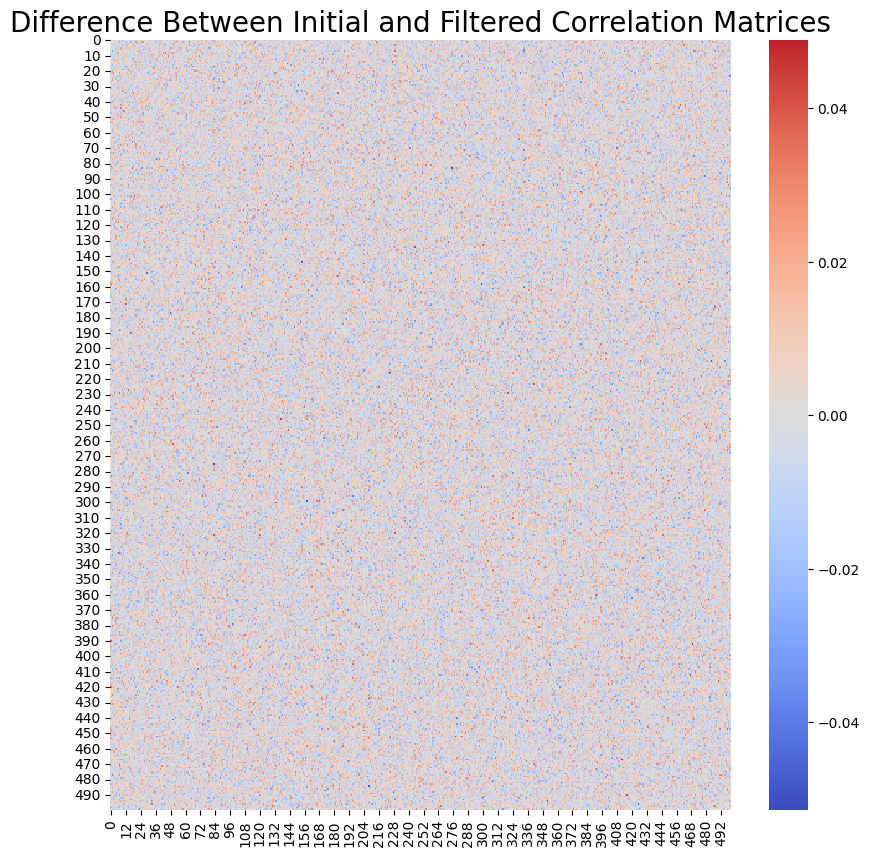

In [62]:
# Reconstruct filtered correlation matrix
reconstructed_corr = eigenvectors @ np.diag(filtered_eigenvalues) @ eigenvectors.T
reconstructed_corr = (reconstructed_corr + reconstructed_corr.T) / 2  # Symmetrize
nearest_corr_matrix = nearest_correlation(reconstructed_corr)

# Scale to covariance matrix
volatility = np.std(rpaths, axis=0)
filtered_cov_matrix = np.outer(volatility, volatility) * nearest_corr_matrix

# Plot difference
plt.figure(figsize=(10, 10))
sns.heatmap(nearest_corr_matrix - corr_matrix, cmap="coolwarm", center=0)
plt.title("Difference Between Initial and Filtered Correlation Matrices", fontsize=20)
plt.show()

In [63]:
# Efficient Frontier
def compute_efficient_frontier(cov_matrix, returns=None):
    """
    Compute the efficient frontier given a covariance matrix and expected returns.
    """
    num_assets = cov_matrix.shape[0]
    if returns is None:
        returns = np.random.uniform(0.01, 0.2, num_assets)  # Simulate random expected returns

    w = cp.Variable(num_assets)
    ret = returns @ w
    risk = cp.quad_form(w, cov_matrix)
    constraints = [cp.sum(w) == 1, w >= 0]

    frontier_returns = []
    frontier_risks = []

    for target_return in np.linspace(min(returns), max(returns), 100):
        prob = cp.Problem(
            Minimize(risk),
            constraints + [ret == target_return]
        )
        prob.solve()
        if prob.status == cp.OPTIMAL:
            frontier_returns.append(target_return)
            frontier_risks.append(np.sqrt(prob.value))

    return frontier_risks, frontier_returns


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


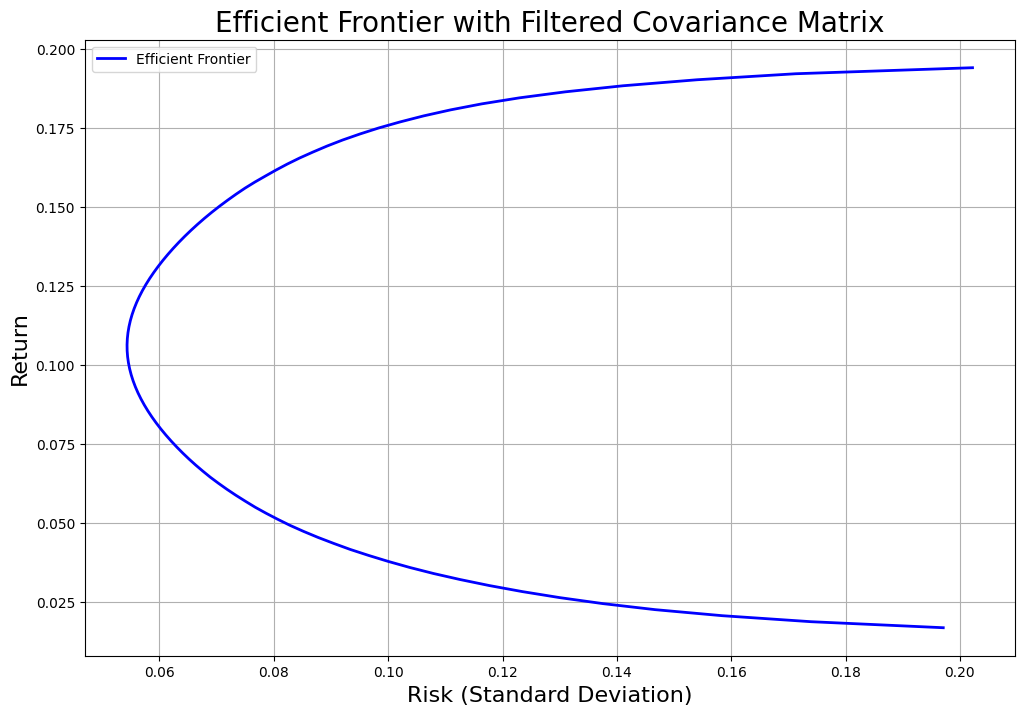

In [64]:
# Calculate efficient frontier
filtered_returns = np.random.uniform(0.01, 0.2, num_srs)  # Simulated returns
risks, returns = compute_efficient_frontier(filtered_cov_matrix, filtered_returns)

# Plot efficient frontier
plt.figure(figsize=(12, 8))
plt.plot(risks, returns, label="Efficient Frontier", color="blue", linewidth=2)
plt.xlabel("Risk (Standard Deviation)", fontsize=16)
plt.ylabel("Return", fontsize=16)
plt.title("Efficient Frontier with Filtered Covariance Matrix", fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

We now construct a noise filtering algorithm based on one developed by Bouchaud and Potters that utilizes the upper bound of this function and apply it to the S&P 500 data.  Specifically, we:

-- Specify a start and end date for the timeseries that we want to consider and compute the mode of the lengths of these series.

-- We keep series that have lengths equal to this mode, compute their daily returns, normalize the variance of each time series to one, and store the result in a dataframe.


In [66]:
def lamplus(n,r):
    '''
    Upper eigenvalue limit of the Marchenko Pastur density
    '''
    q = float(n)/float(r)
    return (1+1/q+2*np.sqrt(1/q))

In [72]:
# Read in closing price data if it is not already a local variable
if 'cell' not in locals():
    df = pd.read_pickle('google_close_price.pkl')
else:
    df = cell

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

dte1 = '2020-01-01'
dte2 = '2023-12-31'

# Convert date strings to datetime objects
start_date = pd.to_datetime(dte1)
end_date = pd.to_datetime(dte2)

# Filter data by date
df_filtered = df[(df.index >= start_date) & (df.index <= end_date)]

# Get unique tickers
tickers = sorted(list(set(df_filtered['Ticker'].values)))

# Find lengths of time series for each ticker
tkrlens = [len(df_filtered[df_filtered.Ticker==tkr]) for tkr in tickers]

# Find mode of time series lengths
tkrmode = mode(tkrlens)  # Ensure to get the mode value correctly

# Identify tickers whose lengths equal the mode
good_tickers = [tickers[i] for i, tkr in enumerate(tkrlens) if tkrlens[i] == tkrmode]


KeyError: 'Date'

We now drop Nans, and compute the correlation matrix between the return time series.  Specifically if $X_i$, $Y_i$ for $i=1,\ldots,n$ are two time series corresponding to normalized daily returns of two stocks $X$ and $Y$ that we are considering, the entry of the correlation matrix corresponding to these two time series is given by

$$
\rho_{XY} = \frac{\mathrm{Cov}(X,Y)}{\sqrt{\mathrm{Var}{X}\mathrm{Var}{Y}}},\quad\mathrm{where}\quad \mathrm{Cov}(X,Y) = \frac{1}{n-1}\sum_{i=1}^n(X_i-\bar{X})(Y_i-\bar{Y}),
$$
$$
\mathrm{Var}(X) = \mathrm{Cov}(X,X), \quad \bar{X} = \frac{1}{n}\sum_{i=1}^n X_i.
$$

Denote the entire correlation matrix by $\rho$ and its corresponding eigenvalue, eigenvector pairs by $(\lambda_i,e_i)$ for $i=1,\ldots, n$ and $\lambda_1\geq \lambda_2\geq \cdots \geq \lambda_n$.

Note that we can write
$$
\rho = \Sigma \Lambda \Sigma^{-1},\quad \mathrm{where} \quad \Sigma = (e_1,\ldots, e_n),\quad \mathrm{and} \quad \Lambda = \mathrm{diag}(\lambda_1,\ldots,\lambda_n),
$$

where we replace $\lambda_i$ with $|\lambda_i|$ in the computation below since we find many of the eigenvalues have a small imaginary part due to numerical error.


In [ ]:
rtndf = rtndf.dropna()
rtndf.columns = good_tickers
non_norm_rtndf = non_norm_rtndf.dropna()
non_norm_rtndf.columns = good_tickers
t,m = rtndf.shape
cmat = rtndf.corr()                   # compute correlation matrix
evls, evcs = la.eig(cmat)             # compute eigenvalue/vector decomposition of matrix
evallst = map(abs,evls)               # take abs of evals (very small imag parts)

We now perform the filtering procedure by first computing the upper noise eigenvalue $\lambda_+$ and then dividing the $\lambda_i$ into two sets $[\lambda_n,\ldots,\lambda_{k}]$ and $[\lambda_{k-1},\ldots,\lambda_1]$ where here $k\leq n$ and $\lambda_{k-1}\leq\lambda_+\leq\lambda_k$.  Filtering consists of replacing all eigenvalues in the first set with the average noise eigenvalue $\tilde{\lambda} = \frac{1}{k-1}\sum_{i=1}^{k-1}\lambda_i$, and defining the altered eigenvalue matrix

$$
\tilde{\Lambda} = \mathrm{diag}(\tilde{\lambda},\ldots,\tilde{\lambda},\lambda_k,\ldots,\lambda_n)
$$

so that $\mathrm{tr}(\Lambda)=\sum_{i=1}^n \lambda_i= (k-1)\tilde{\lambda}+\sum_{i=k}^n\lambda_i =\mathrm{tr}(\tilde{\Lambda})=n$, i.e. we do not alter the trace

In [ ]:
filtvals = [val for val in evallst if val < lamplus(t,m)]     # filter eigenvalues
sevlist = [np.mean(filtvals)]*len(filtvals)
feval = evallst[:(len(evallst)-len(sevlist))] + sevlist       # build list of new eigenvalues

The final portion of the filtering problem consists of reconstructing the correlation matrix from the filtered eigenvalues, in particular, we compute

$$
\tilde{\rho} = \Sigma\tilde{\Lambda}\Sigma^{-1}
$$

Next we symmetrize $\tilde{\rho}$

$$
\tilde{\rho}_1 = \frac{1}{2}(\tilde{\rho}+\tilde{\rho}^T)
$$

We finally note that $\tilde{\rho}_1$ is not guarenteed to be a true correlation matrix, specifically, the diagonal entries are not always $1$'s.   Thus we search over the space of positive definite, symmetric matrices with ones on the main diagonal to find the one that most closely matches the candidate matrix in the Frobenius norm sense. We consider the following opimization problem:

$$
\hat{\rho} = \min_{x\in S} ||x - \tilde{\rho}_1 ||^2_F,\quad\mathrm{where}\quad S = [x\in\mathrm{GL}(N),\:x = x^T,\:  x_{ii}=1,\: \lambda_i(x) > 0 ],
$$
$$
\quad\mathrm{and}\quad || x - y||_F^2 = \sum_{i,j=1}^n (x_{ij}-y_{ij})^2
$$

We apply an open source optimizer (due to Mike Croucher available at: https://github.com/mikecroucher/nearest_correlation) that is tailored to this problem in the nearcorr function below

In [ ]:
rcmat = abs(np.dot(np.dot(evcs,np.diag(feval)),la.inv(evcs))) # reconstruct candidate correlation matrix
rcmat = (rcmat + rcmat.T)/2                                   # symmetrize the candidate matrix
ncorr = nearcorr(rcmat, max_iterations=1000)                  # find nearest correlation matrix

We plot the top ten eigenvalues of our S&P 500 correlation matrix as well as a histogram of the smaller eigenvalues overlaid with the Marchenko Pastur density below.

[ 186.48218152   14.73556411    9.51981203    6.72486409    5.37382408
    4.50626454    3.8396991     3.16109878    3.03215959    2.65077285]


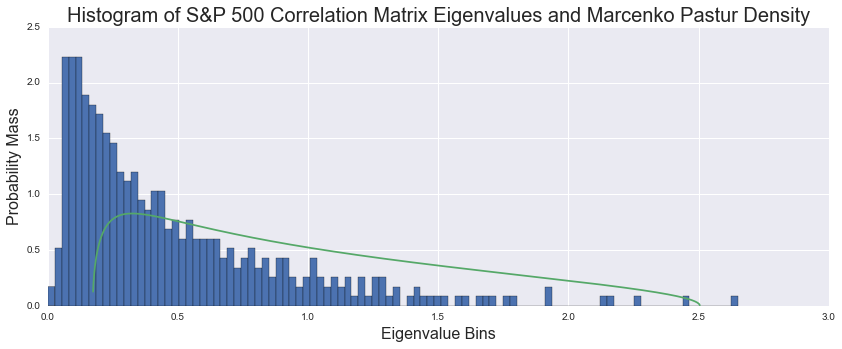

In [ ]:
print evls[0:10]
plt.figure(figsize=(14,5))
plt.hist([val for val in evls if val < 3],bins=100,normed=True);
plt.plot(lamvls,[eigden(lam,len(rtndf),len(rtndf.columns)) for lam in lamvls]);
plt.xlabel("Eigenvalue Bins",fontsize=16)
plt.ylabel("Probability Mass",fontsize=16)
plt.title("Histogram of S&P 500 Correlation Matrix Eigenvalues and Marcenko Pastur Density", fontsize=20)

We now display a matrix heatmap plot of the differences between the original and filtered correlation matricies as well as a histogram of all differences below

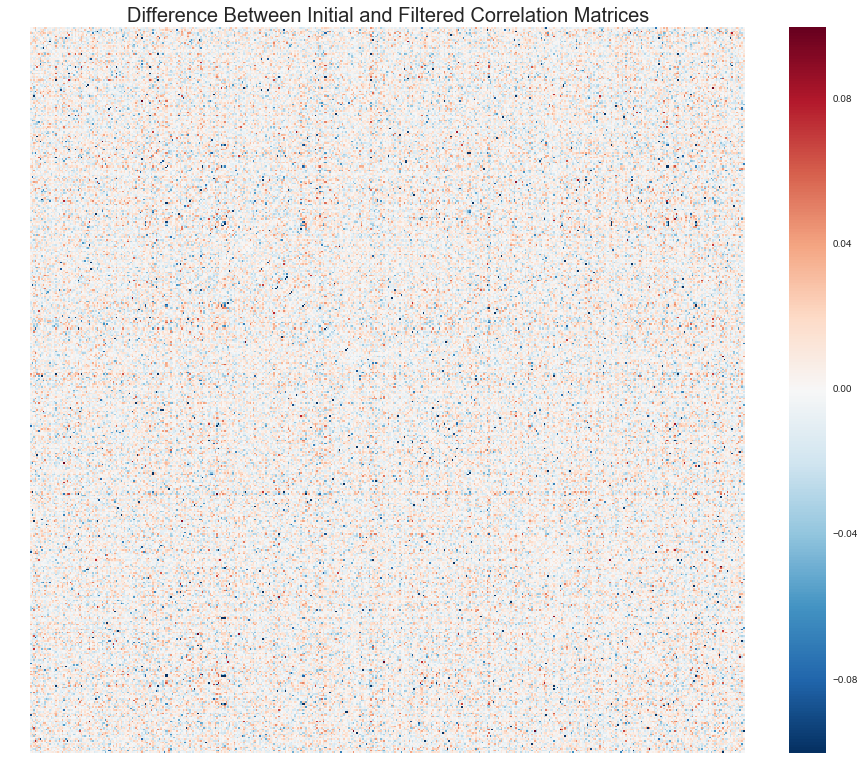

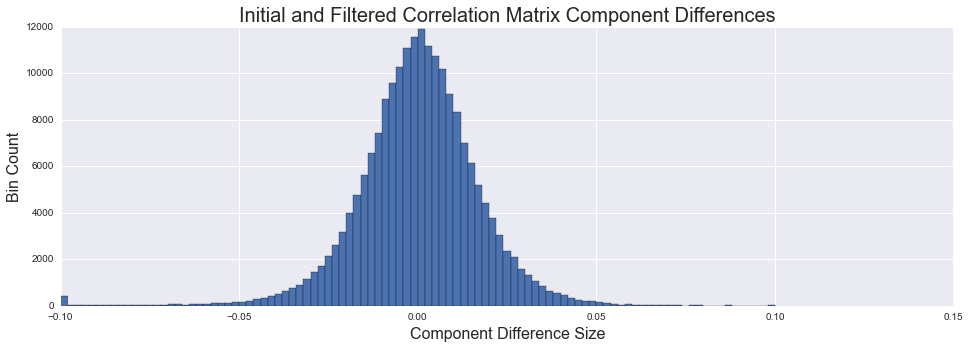

In [ ]:
plt.figure(figsize=(16,13))
corrdiff = np.array(ncorr - cmat)
corrdiff = np.array([map(lambda x: min(x,0.1), row) for row in corrdiff])
corrdiff = np.array([map(lambda x: max(x,-0.1), row) for row in corrdiff])
sns.heatmap(corrdiff)
plt.axis('off')
plt.title('Difference Between Initial and Filtered Correlation Matrices', fontsize=20)

plt.figure(figsize=(16,5))
plt.hist(corrdiff.flatten(),bins = 100)
plt.xlabel("Component Difference Size",fontsize=16)
plt.ylabel("Bin Count",fontsize=16)
plt.title("Initial and Filtered Correlation Matrix Component Differences", fontsize=20)
plt.show()

We now reconstruct the covariance matricies associated with both the raw and filtered correlation matricies as well as the vector of expected daily returns of each stock   

In [ ]:
ocov = np.array([[std_lst[i]*std_lst[j]*cmat.as_matrix()[i][j] for i in xrange(0,len(std_lst))] for j in xrange(0,len(std_lst))])
ncov = np.array([[std_lst[i]*std_lst[j]*ncorr[i][j] for i in xrange(0,len(std_lst))] for j in xrange(0,len(std_lst))])
dly_rtn = np.array(non_norm_rtndf.cumsum().tail(1)/len(non_norm_rtndf))[0]

We use CVXPY (http://www.cvxpy.org/en/latest/) created by Steven Diamond a new simple interface to multiple open source convex optimizers including CVXOPT, ECOS, SCS as well as proprietary optimizers in order to solve the following Markowitz type asset allocation problem:

Given an estimated covariance matrix $\hat{\Sigma}$ of daily returns and an expected daily return $\hat{\mu}$, we seek to find the asset weights $w=[w_1,\ldots,w_n]$ by solving the following optimization problem:

$$
\hat{w} = \underset{w}{\mathrm{argmin}}\:\: w^T\hat{\Sigma}w - \lambda\hat{\mu}^T w + \gamma|w|_1, \quad |w|_1 = \sum_{i=1}^n |w_i|,
$$

subject to the constraints that $\sum w_i = 1$. We note that the regularization term was choosen to prefer long/short portfolios that consist of only a small number stocks (which is more practical from a trading perspective).  This also enhances the stability of the optimization procedure.

Below, we solve this problem for varying $\lambda$ values while fixing $\mu=0.003$.



In [ ]:
lam = np.linspace(-2,2,200)

def mv_opt_port(cov,dly_rtn,div_param,lam_lst):
    n = len(cov)
    vlst = []
    rtnlst = []

    for v in lam_lst:
        x = Variable(n)
        objective = Minimize(quad_form(x,cov)-v*dly_rtn.T*x + div_param*norm(x,1))
        constraints = [sum_entries(x)==1]
        p = Problem(objective, constraints)
        L = p.solve()

        wopt = np.array(x.value).flatten()
        vlst.append(wopt.T.dot(ocov).dot(wopt))
        rtnlst.append(wopt.dot(dly_rtn))

    return (wopt,vlst, rtnlst)


wopt, vtmp, rtntmp = mv_opt_port(ocov, dly_rtn, 0.003, lam)
wopt1, vtmp1, rtntmp1 = mv_opt_port(ncov, dly_rtn, 0.003, lam)


We now plot the efficient frontier of both models; this is constructed by varying the $\lambda$ parameter and for each value solving the above optimization problem and saving the expected return and volatility of the associated optimal portfolio.

We plot both efficient frontiers in blue and green below as well as the volatility and expected returns for each of individual stocks we considered in a scatter plot.

Note that the results do not significantly differ.

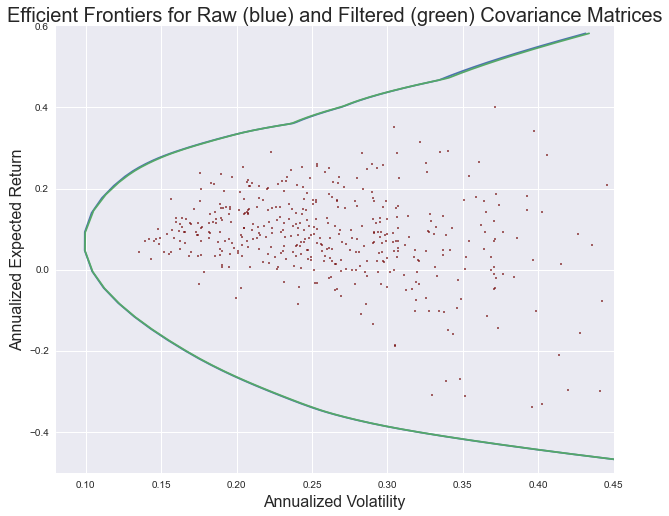

In [ ]:
plt.figure(figsize=(10,8))

xplt = 252*np.array(vtmp)
yplt = 252*np.array(rtntmp)
x1plt = 252*np.array(vtmp1)
y1plt = 252*np.array(rtntmp1)

pltvec=pd.concat([non_norm_rtndf.std(),non_norm_rtndf.mean()],axis=1).as_matrix()
pltarr = pd.concat([non_norm_rtndf.std(),non_norm_rtndf.mean()],axis=1).as_matrix()
pltarr = np.array([val for val in pltarr if val[0]<0.1])
plt.scatter(np.sqrt(252)*pltarr.T[0],252*pltarr.T[1],s=2,c='r')
plt.plot(np.sqrt(xplt),yplt, np.sqrt(x1plt),y1plt)
plt.xlim(0.08,0.45)
plt.ylim(-0.5,0.6)
plt.xlabel("Annualized Volatility",fontsize=16)
plt.ylabel("Annualized Expected Return",fontsize=16)
plt.title("Efficient Frontiers for Raw (blue) and Filtered (green) Covariance Matrices", fontsize=20)
plt.show()

References:

Email: steve98654-at-gmail-dot-com

CVXPY -- http://www.cvxpy.org/en/latest/

Talk on GitHub: https://github.com/steve98654/PyTalk/  (file corr_filt.ipynb)

Bouchaud and Potters: Financial Applications of Random Matrix Theory (a short review) http://arxiv.org/pdf/0910.1205.pdf

Marchenko,V. A., Pastur, L. A. (1967) "Distribution of eigenvalues for some sets of random matrices", Mat. Sb. (N.S.), 72(114):4, 507–536
